<img alt="(C)2020, 해킹대응기술연구실" src="http://ocslab.hksecurity.net/logo_hcrl.svg" alt="Drawing" style="width: 300px;" align="right" onerror="this.src='http://ocslab.hksecurity.net/logo_hcrl.svg'"/>

# 자동차 내부네트워크 침입탐지 데모

## 데이터셋 분석 실습


- YF 쏘나타에서 수집한 실제 정상 데이터와 이상 데이터를 관찰하고 분석한다.
- **Time-interval** 관점, **Entropy** 관점에서 차량 내 이상징후 탐지를 위해 `Arbitration_ID` 필드를 중심으로 분석을 수행한다.
- 실시간 탐지를 위한 threshold 값을 추출한다.
    - **Time-interval**: `Arbitration_ID` 필드 별 메시지 발생 주기
    - **Entropy**: CAN bus 전체에 대한 엔트로피값

---

# 분석에 필요한 라이브러리 로드하기

- pandas: 데이터 분석 라이브러리
- matplotlib: 그래프 시각화 라이브러리
- numpy: 파이썬을 위한 고급 수식 계산 라이브러리
- sklearn: 머신러닝 라이브러리 (오늘은 침입 탐지 성능 평가시에만 사용)

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

pd.options.display.float_format = '{:.5f}'.format # Timestamp 출력 시 소수점 이하 다섯자리까지만 표현한다.

# 1. 데이터셋 소개

- `attack_free_dataset.txt`: 차량에서 발생되는 정상 데이터셋
- `KU-CISC2017_OTIDS_3rd.txt`: [데이터 챌린지 2017 - 차량 데이터셋 세션](http://datachallenge.kr/challenge17/car/challenge/) 본선 데이터셋

In [3]:
filename_benign = 'attack_free_dataset.txt'
filename_challenge = 'KU-CISC2017_OTIDS_3rd.txt'

!head KU-CISC2017_OTIDS_3rd.txt

Timestamp: 1479246664.161722        ID: 0430    000    DLC: 8    00 00 00 00 00 00 00 00
Timestamp: 1479246664.161952        ID: 04b1    000    DLC: 8    00 00 00 00 00 00 00 00
Timestamp: 1479246664.162199        ID: 01f1    000    DLC: 8    08 00 00 00 00 00 00 00
Timestamp: 1479246664.162438        ID: 0153    000    DLC: 8    00 21 10 ff 00 ff 00 00
Timestamp: 1479246664.162688        ID: 0002    000    DLC: 8    00 00 00 00 00 06 00 bf
Timestamp: 1479246664.163846        ID: 0130    000    DLC: 8    ff 7f 00 ff b2 7f 00 93
Timestamp: 1479246664.164078        ID: 0131    000    DLC: 8    12 80 00 00 56 80 00 1d
Timestamp: 1479246664.164321        ID: 0140    000    DLC: 8    00 00 00 00 0c 32 20 de
Timestamp: 1479246664.164967        ID: 02b0    000    DLC: 5    bd ff 00 07 dc
Timestamp: 1479246664.165822        ID: 043f    000    DLC: 8    00 40 60 ff 58 28 08 00


## 1.1. 데이터셋 읽기

텍스트 데이터를 파싱하여 DataFrame으로 읽어옴

In [4]:
def path_to_dataframe(path: str) -> pd.DataFrame:
    with open(path, 'rt') as fp:
        lines = fp.read().splitlines()
    for i in range(len(lines)):
        data = lines[i].split()
        timestamp, arbitration_id, control_field, dlc = (float(data[1]), int(data[3], 16), data[4], data[6])
        payload = bytes.fromhex(''.join(data[7:]))
        lines[i] = (timestamp, arbitration_id, control_field, dlc, payload)
    return pd.DataFrame(data=lines, columns=['timestamp', 'arbitration_id', 'control_field', 'dlc', 'payload'])


df_benign = path_to_dataframe(filename_benign)
df_challenge = path_to_dataframe(filename_challenge)
# it takes a time.

In [5]:
print(df_benign.shape, df_challenge.shape)
df_challenge.head()

(3713144, 5) (1016749, 5)


,timestamp,arbitration_id,control_field,dlc,payload
0,1479246664.16172,1072,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00'
1,1479246664.16195,1201,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00'
2,1479246664.16220,497,000,8,b'\x08\x00\x00\x00\x00\x00\x00\x00'
3,1479246664.16244,339,000,8,b'\x00!\x10\xff\x00\xff\x00\x00'
4,1479246664.16269,2,000,8,b'\x00\x00\x00\x00\x00\x06\x00\xbf'


## 1.2. Timestamp 처리하기

`timestamp`를 상대시간 `timedelta`로 변경해야 데이터를 분석하기 수월하다.

In [6]:
df_challenge['timestamp']

0         1479246664.16172
1         1479246664.16195
2         1479246664.16220
3         1479246664.16244
4         1479246664.16269
                ...       
1016744   1479247257.59000
1016745   1479247257.59024
1016746   1479247257.59043
1016747   1479247257.59066
1016748   1479247257.59091
Name: timestamp, Length: 1016749, dtype: float64

`timestamp` 필드의 최솟값을 이용해 시간 데이터를 전처리하고 `timedelta` 필드를 생성한다.

In [7]:
df_benign['timedelta'] = df_benign['timestamp'] - df_benign['timestamp'].min()
df_challenge['timedelta'] = df_challenge['timestamp'] - df_challenge['timestamp'].min()

In [8]:
df_challenge['timedelta']

0           0.00000
1           0.00023
2           0.00048
3           0.00072
4           0.00097
             ...   
1016744   593.42828
1016745   593.42852
1016746   593.42870
1016747   593.42894
1016748   593.42919
Name: timedelta, Length: 1016749, dtype: float64

In [9]:
print('정상 데이터셋 캡쳐시간: {}초'.format(df_benign['timedelta'].max()))
print('챌린지 데이터셋 캡쳐시간: {}초'.format(df_challenge['timedelta'].max()))

정상 데이터셋 캡쳐시간: 1904.283226초
챌린지 데이터셋 캡쳐시간: 593.4291911125183초


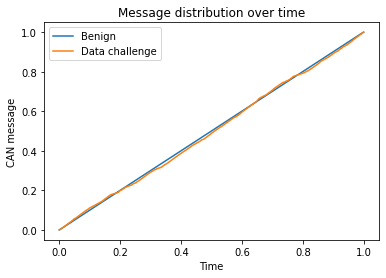

In [10]:
plt.title('Message distribution over time')
plt.xlabel('Time')
plt.ylabel('CAN message')

plt.plot(df_benign['timedelta'] / df_benign['timedelta'].max(), df_benign.index / df_benign.index.max(), label='Benign')
plt.plot(df_challenge['timedelta'] / df_challenge['timedelta'].max(), df_challenge.index / df_challenge.index.max(), label='Data challenge')
plt.legend()

Q. 정상 데이터와 이상 데이터간 차이가 보이는가?

## 1.3. 레이블 달기

정답지 내용 살펴보기

In [11]:
!cat 정답지.csv

1479246689.43625, 1479246692.92260, DoS
1479246719.28941, 1479246722.81242, Fuzzy
1479246748.90351, 1479246755.08499, Replay
1479246779.29343, 1479246782.75008, DoS
1479246809.49485, 1479246812.71972, Fuzzy
1479246841.85756, 1479246848.66088, Replay
1479246869.37992, 1479246872.88905, DoS
1479246899.34165, 1479246902.91397, Fuzzy
1479246925.83007, 1479246935.77888, Replay
1479246959.48647, 1479246962.74539, DoS
1479246989.34744, 1479246992.92711, Fuzzy
1479247016.32607, 1479247023.72336, Replay
1479247049.28685, 1479247053.07396, DoS
1479247079.41421, 1479247082.72012, Fuzzy
1479247111.82587, 1479247119.39588, Replay
1479247139.29051, 1479247142.82626, DoS
1479247169.39301, 1479247172.94746, Fuzzy
1479247205.54192, 1479247226.58453, Replay
1479247235.09898, 1479247237.85495, DoS
1479247259.56948, 1479247262.95860, Fuzzy


`labels` 리스트에 정답지 정보를 저장

In [12]:
# 정답지 불러오기
labels = list()
with open('정답지.csv', 'rt') as fp:
    lines = fp.read().splitlines()
for line in lines:
    data = [x.strip() for x in line.split(',')]
    ts_start, ts_end, label = float(data[0]), float(data[1]), data[2]
    labels.append((ts_start, ts_end, label))

# 정답지를 0 or 1로 달아주는 함수
def make_label(timestamp: float) -> str:
    assert isinstance(timestamp, float)
    for ts_start, ts_end, label in labels:
        if ts_start <= timestamp <= ts_end:
            return 1
    return 0

# 상세한 공격 종류를 달아주는 함수
def make_label_descrition(timestamp: float) -> str:
    assert isinstance(timestamp, float)
    for ts_start, ts_end, label in labels:
        if ts_start <= timestamp < ts_end:
            return label
    return 'benign'

특정 필드를 선택하고 `apply()` 함수를 호출하면 해당 필드의 값이 함수로 입력되고, 함수의 출력이 새로운 필드로 저장됨

In [13]:
df_benign['label'] = 0 # 모든 메시지가 정상임
df_challenge['label'] = df_challenge['timestamp'].apply(make_label)
df_challenge['label_desc'] = df_challenge['timestamp'].apply(make_label_descrition)

In [14]:
df_challenge['label_desc'].value_counts()

benign    815274
Replay    106278
DoS        55388
Fuzzy      39809
Name: label_desc, dtype: int64

In [15]:
df_challenge['label'].value_counts()

0    815274
1    201475
Name: label, dtype: int64

## 1.4 pandas 사용법

### 1.4.1 row/column selection

In [16]:
df_benign['timedelta']

0            0.00000
1            0.03225
2            0.04050
3            0.04170
4            0.05002
             ...    
3713139   1904.27515
3713140   1904.27541
3713141   1904.27570
3713142   1904.27685
3713143   1904.28323
Name: timedelta, Length: 3713144, dtype: float64

In [17]:
df_benign[100:103]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label
100,2.30105,688,000,5,b'W\x00\x00\x07\xc9\x02)\xf8',0.21672,0
101,2.30478,1264,000,8,b'\x00\x00\x00\xc0\x00\xeb\xb6\x13',0.22044,0
102,2.30664,1072,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.22230,0


In [18]:
condition = df_benign['timedelta'] > 100 #추출 100초 이후 트래픽
df_benign[condition]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label
194754,102.08504,1520,000,2,b'\x00\x00/\x00\x00\x00\x00\x00',100.00071,0
194755,102.08719,1264,000,8,b'\x00\x1d\x00\x80\x00\xef\xb6\x13',100.00285,0
194756,102.08843,688,000,5,b'\x0f\xff\n\x07\xec\xef\xb6\x13',100.00410,0
194757,102.08872,399,000,8,b'\xfeC\x00\x00\x00e\x00\x00',100.00439,0
194758,102.08945,608,000,8,b'\x1c\x1f\x150\x00\xa4e0',100.00512,0
...,...,...,...,...,...,...,...
3713139,1906.35949,672,000,8,b'@\x00x\x1d\xec\x01\xab\x00',1904.27515,0
3713140,1906.35975,809,000,8,"b""\x0c\xb4\x81\x16\x11'\x00\x14""",1904.27541,0
3713141,1906.36003,1349,000,8,b'\xe1\x00\x00\n\x00\x00\x00\x00',1904.27570,0
3713142,1906.36119,1264,000,8,"b""\x00\x00\x00\x80\x00'\xb7\x13""",1904.27685,0


In [19]:
df_benign['timedelta'].min(), df_benign['timedelta'].max(), df_benign['timedelta'].mean(), df_benign['timedelta'].std()

(0.0, 1904.283226, 951.0999154286714, 548.9699706557884)

In [20]:
print(df_benign['arbitration_id'].unique())

[1520 1264 1680  304  305  320 1072 1201  497  339    2  688 1440 1442
  704  790  399  608  672  809  880 1087 1088 1349  160  161  848]


In [21]:
df_benign['arbitration_id'].value_counts()

790     190555
809     190554
1349    190554
399     190554
608     190554
672     190554
704     190489
304     190041
305     190041
320     190041
339     190039
2       190039
880     190003
1087    190003
1088    190003
848     189990
688     189884
1264     95213
1072     95020
497      95020
1201     95020
1520     38009
161      19055
160      19055
1680     19044
1440      1905
1442      1905
Name: arbitration_id, dtype: int64

---

# 2. 자동차 데이터 분석
## 2.1. arbitration_id 별 정상 데이터셋 분석


In [53]:
def describe_can_dataset(df: pd.DataFrame) -> None:
    total_count = df.shape[0]
    aids = df['arbitration_id'].unique()
    aids.sort()
    print('\t'.join(['Index', 'Arb_ID', 'Count', 'Ratio', 'avg(t)','min(t)', 'max(t)', 'std(t)', 'distinct(payload)']))
    for idx, aid in enumerate(aids):
        df_aid = df[df['arbitration_id']==aid] # 특정 AID에 대한

        count = df_aid.shape[0]
        time_interval = df_aid['timedelta'] - df_aid['timedelta'].shift()
        time_interval_avg = time_interval.mean()
        time_interval_min = time_interval.min()
        time_interval_max = time_interval.max()
        time_interval_stdev = time_interval.std()
        num_uniq_values = df_aid['payload'].nunique()
        print('{idx}\t{aid:4d}\t{count:7,}\t{ratio:.2%}\t{t_avg:.03f}\t{t_min:.03f}\t{t_max:.03f}\t{t_std:.03f}\t{num_uniq_values:17,}'.format(
            idx=idx, aid=aid, count=count, ratio=count/total_count, 
            t_avg=time_interval_avg, t_min=time_interval_min, t_max=time_interval_max, t_std=time_interval_stdev,
            num_uniq_values=num_uniq_values))

describe_can_dataset(df_benign)
df_benign

Index	Arb_ID	Count	Ratio	avg(t)	min(t)	max(t)	std(t)	distinct(payload)
0	   2	190,039	5.12%	0.010	0.001	0.061	0.002	              153
1	 160	 19,055	0.51%	0.100	0.046	0.143	0.001	           12,514
2	 161	 19,055	0.51%	0.100	0.046	0.143	0.001	            3,638
3	 304	190,041	5.12%	0.010	0.001	0.066	0.001	          170,945
4	 305	190,041	5.12%	0.010	0.001	0.071	0.001	          133,882
5	 320	190,041	5.12%	0.010	0.001	0.074	0.001	              348
6	 339	190,039	5.12%	0.010	0.001	0.058	0.001	                1
7	 399	190,554	5.13%	0.010	0.001	0.059	0.001	            1,639
8	 497	 95,020	2.56%	0.020	0.004	0.074	0.000	           47,183
9	 608	190,554	5.13%	0.010	0.001	0.055	0.001	           92,015
10	 672	190,554	5.13%	0.010	0.001	0.053	0.001	              100
11	 688	189,884	5.11%	0.010	0.001	0.062	0.001	          111,440
12	 704	190,489	5.13%	0.010	0.001	0.058	0.001	                2
13	 790	190,555	5.13%	0.010	0.001	0.073	0.001	           62,553
14	 809	190,554	5.13%	0.010	0.001	0.054	0.0

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label,interval,predicted_as,entropy
0,2.08433,1520,000,2,b'\x00\x00\x0e\x00\x00\x00\x00\x00',0.00000,0,nan,0,3.05391
1,2.11659,1264,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.03225,0,nan,0,3.05391
2,2.12484,1680,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.04050,0,nan,0,3.05391
3,2.12604,1264,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.04170,0,0.00945,1,3.05391
4,2.13435,1520,000,2,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.05002,0,0.05002,0,3.05391
...,...,...,...,...,...,...,...,...,...,...
3713139,1906.35949,672,000,8,b'@\x00x\x1d\xec\x01\xab\x00',1904.27515,0,0.01013,0,2.06335
3713140,1906.35975,809,000,8,"b""\x0c\xb4\x81\x16\x11'\x00\x14""",1904.27541,0,0.01012,0,2.06335
3713141,1906.36003,1349,000,8,b'\xe1\x00\x00\n\x00\x00\x00\x00',1904.27570,0,0.01013,0,2.06335
3713142,1906.36119,1264,000,8,"b""\x00\x00\x00\x80\x00'\xb7\x13""",1904.27685,0,0.01984,0,2.06335


## 2.2 자동차 트래픽 이해하기
### Category 1. 동일한 데이터만 관찰되는 경우

distinct(payload) 값이 1인 경우 해당 arbitration ID는 오직 한 가지 종류의 데이터만 송수신함을 의미

In [23]:
df_benign[df_benign['arbitration_id']==339]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label
23,2.20823,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',0.12390,0
27,2.21762,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',0.13329,0
36,2.22824,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',0.14390,0
45,2.23752,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',0.15318,0
54,2.24794,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',0.16361,0
...,...,...,...,...,...,...,...
3710134,1902.48342,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',1900.39909,0
3710146,1902.49061,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',1900.40628,0
3710174,1902.50357,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',1900.41924,0
3710185,1902.51111,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',1900.42677,0


### Category 2.  데이터 필드가 순환하는 경우
#distinct(payload) 값이 상대적으로 적은 경우, 해당 arbitration ID는 순환하는 데이터를 가짐

In [24]:
df_benign[df_benign['arbitration_id']==1442].head(20)

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label
85,2.28674,1442,000,8,b'\t\x00\x00\x00\x00\x00\x00\x00',0.20241,0
1887,3.30695,1442,000,8,b'\x04F\x93\x04\x00\x00\x00\x00',1.22261,0
3836,4.30603,1442,000,8,b'\x04\x02\x91\x04\x00\x00\x00\x00',2.22169,0
5780,5.30379,1442,000,8,b'\x04\x00\xa5\x04\x00\x00\x00\x00',3.21945,0
7732,6.30380,1442,000,8,b'\x04G\x93\x04\x00\x00\x00\x00',4.21947,0
9681,7.30251,1442,000,8,b'\x04F\x93\x04\x00\x00\x00\x00',5.21818,0
11633,8.30167,1442,000,8,b'\x04\x02\x91\x04\x00\x00\x00\x00',6.21734,0
13585,9.30041,1442,000,8,b'\x05\x00\xa5\x04\x00\x00\x00\x00',7.21608,0
15537,10.29953,1442,000,8,b'\x05G\x93\x04\x00\x00\x00\x00',8.21519,0
17489,11.29869,1442,000,8,b'\x05F\x93\x04\x00\x00\x00\x00',9.21435,0


### Category 3. 일반적인 통신 데이터

CAN 메시지는 차량 주행에 필요한 다양한 데이터값을 가지며, Time Interval의 표준편차가 0.1 미만으로 작음

In [25]:
df_benign[df_benign['arbitration_id']==688]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label
25,2.21087,688,000,5,b'W\x00\x00\x07P\x08\x00P',0.12654,0
31,2.22114,688,000,5,b'W\x00\x00\x07A)$/',0.13680,0
41,2.23135,688,000,5,"b'W\x00\x00\x07r\x12""\x98'",0.14701,0
49,2.24154,688,000,5,b'W\x00\x00\x07c\x00\x00\x00',0.15721,0
59,2.25094,688,000,5,b'W\x00\x00\x07\x14\x02$d',0.16660,0
...,...,...,...,...,...,...,...
3710107,1902.47122,688,000,5,b'\xba\xff\x00\x07\x17\xff\x00\x00',1900.38689,0
3710123,1902.48133,688,000,5,b'\xba\xff\x00\x07\xe8\x00\x00\x00',1900.39700,0
3710147,1902.49067,688,000,5,b'\xba\xff\x00\x07\xf9\xff\x00\x00',1900.40634,0
3710163,1902.50153,688,000,5,b'\xba\xff\x00\x07\xca\x00\x00\x00',1900.41719,0


#### CAN 통신 데이터 해석 실습

예를 들어, `arbitrtation_id==790`인 경우 `payload[2]`, `payload[3]`이 엔진 RPM 정보를 가짐. 그리고, `payload[6]`이 자동차 속도 정보를 가짐

$$ RPM = \frac{payload[3] || payload[2]}{4}$$

$$ Speed = payload[6]$$

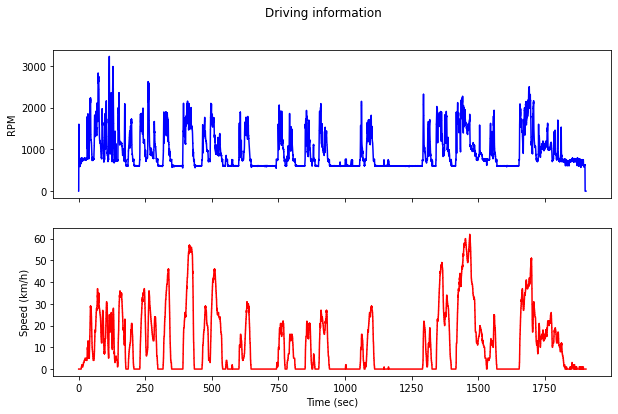

In [26]:
def get_speed(payload: bytes) -> int:
    return payload[6]
def get_rpm(payload: bytes) -> int:
    return int((payload[3]<<8 | payload[2])/4)

df_driving_info = df_benign[df_benign['arbitration_id']==790]

speed = df_driving_info['payload'].apply(get_speed)
rpm = df_driving_info['payload'].apply(get_rpm) 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
fig.suptitle('Driving information')
ax1.set_ylabel('RPM')
ax1.plot(df_driving_info['timedelta'], rpm, color='blue')
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Speed (km/h)')
ax2.plot(df_driving_info['timedelta'], speed, color='red')

fig.show()

 약 30분간 60km 제한 속도의 시내 구간을 주행했을 것으로 추정할 수 있음

## 2.3. arbitration_id 별 데이터 챌린지 데이터셋 살펴보기

In [27]:
describe_can_dataset(df_challenge)

.00%	nan	nan	nan	nan	                1
1125	1314	      3	0.00%	90.837	0.082	181.592	128.347	                3
1126	1315	      2	0.00%	181.456	181.456	181.456	nan	                2
1127	1316	      2	0.00%	0.972	0.972	0.972	nan	                2
1128	1317	      2	0.00%	360.842	360.842	360.842	nan	                2
1129	1318	      3	0.00%	180.954	0.782	361.126	254.801	                3
1130	1319	      1	0.00%	nan	nan	nan	nan	                1
1131	1321	      4	0.00%	120.715	0.837	359.833	207.082	                4
1132	1323	      2	0.00%	1.353	1.353	1.353	nan	                2
1133	1325	      2	0.00%	0.307	0.307	0.307	nan	                2
1134	1326	      2	0.00%	0.589	0.589	0.589	nan	                2
1135	1327	      1	0.00%	nan	nan	nan	nan	                1
1136	1329	      2	0.00%	361.881	361.881	361.881	nan	                2
1137	1330	      1	0.00%	nan	nan	nan	nan	                1
1138	1331	      3	0.00%	91.317	0.840	181.794	127.954	                3
1139	1333	      1	0.00%	nan	nan	nan

Q. 수많은 arbitration_id는 모두 정상 트래픽인가?

Q. `label==0`인 경우(=공격이 발생중이지 않은 경우) arbitration_id는 얼마나 많이 등장하는가?

---

# 3. Time-interval based intrusion detection

앞서 살펴본 정상 상황에서의 CAN 메시지 발생 주기 특징을 활용해 time-interval 기반의 침입 탐지 알고리즘을 작성한다.

- CAN 데이터는 각 Arbitration ID 마다 주기성을 가지고 있으며, 그 주기를 Time Interval로 정의함
- 공격이 발생하게 되면, CAN 버스에 추가적인 데이터가 주입되므로 데이터의 발생 주기가 짧아짐.
- CAN 버스에 흐르는 데이터의 Time Interval을 측정하여, 해당 데이터의 Time Interval이 정상 Time Interval의 절반 이하가 되면 공격으로 간주함.

## 3.1 Arbitration ID 별 time-interval 확인
정상 데이터에서 각 Arbitration ID 별 Time Interval을 확인하고, 해당 Time Interval을 공격을 탐지하는데 사용함

0
1
2


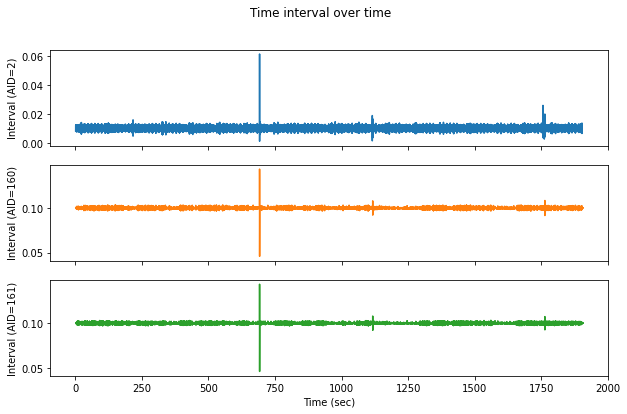

In [55]:
def plot_time_intervals(df: pd.DataFrame, aids: list) -> None:
    fig, axs = plt.subplots(len(aids), 1, figsize=(10, 2*len(aids)), sharex=True)
    fig.suptitle('Time interval over time')
    if len(aids) == 1: 
        axs = [axs, ]
    for i, aid in enumerate(aids):
        df_aid = df[df['arbitration_id']==aid]
        time_interval = df_aid['timedelta'] - df_aid['timedelta'].shift()

        ax = axs[i]
        ax.plot(df_aid['timestamp'], time_interval, color='C{}'.format(i%10))
        ax.set_ylabel('Interval (AID={})'.format(aid))
    ax.set_xlabel('Time (sec)')

plot_time_intervals(df_benign, [2, 160, 161])
# plot_time_intervals(df_benign, df_benign['arbitration_id'].unique()) # it takes a time.

## 3.2 침입 탐지를 위한 threshold 결정

침입 탐지를 위해 평균 time interval 대비 50% 이내로 들어오는 경우 공격으로 탐지 (`ABNORMAL_INTERVAL_RATIO = 0.7`)

In [29]:
aids = df_benign['arbitration_id'].unique()
aids.sort()
print('available aids: ', aids)

dict_avg_interval = dict() # 메시지 발생 평균 인터벌
for aid in aids:
    df_aid = df_benign[df_benign['arbitration_id']==aid]
    time_interval = df_aid['timedelta'] - df_aid['timedelta'].shift()
    dict_avg_interval[aid] = time_interval.mean()

print('\narbitration id의 평균 발생 주기: ', dict_avg_interval)

dict_thresholds = dict()      # 메시지 발생 평균 인터벌에 ABNORMAL_INTERVAL_RATIO를 곱한 값
ABNORMAL_INTERVAL_RATIO = 0.5 # 침입 탐지 threshold ratio
for aid in dict_avg_interval:
    dict_thresholds[aid] = dict_avg_interval[aid] * ABNORMAL_INTERVAL_RATIO

print('\n***ABNORMAL_INTERVAL_RATIO = {}***'.format(ABNORMAL_INTERVAL_RATIO))
print('***탐지를 위한 threshold***')
for aid in dict_thresholds:
    print('{:4d}\t{:.03f}'.format(aid, dict_thresholds[aid]))

available aids:  [   2  160  161  304  305  320  339  399  497  608  672  688  704  790
  809  848  880 1072 1087 1088 1201 1264 1349 1440 1442 1520 1680]

arbitration id의 평균 발생 주기:  {2: 0.00999964993317126, 160: 0.09991797554319304, 161: 0.09991801779153985, 304: 0.009999820137865711, 305: 0.00999981722795201, 320: 0.009999815607240581, 339: 0.009999650496216546, 399: 0.009991800968759349, 497: 0.019999302118523667, 608: 0.009991802070814943, 672: 0.00999180241192739, 688: 0.01000774318396065, 704: 0.009991337769308302, 790: 0.009991799736557616, 809: 0.009991799651540517, 848: 0.009996413771323603, 880: 0.010000634193324281, 1072: 0.01999930350771951, 1087: 0.010000625988147493, 1088: 0.01000063416700877, 1201: 0.01999930319199318, 1264: 0.02000004831323783, 1349: 0.00999179989294317, 1440: 0.9991447778361345, 1442: 0.9991447647058824, 1520: 0.05000058540307304, 1680: 0.09999610791366909}

***ABNORMAL_INTERVAL_RATIO = 0.5***
***탐지를 위한 threshold***
   2	0.005
 160	0.050
 161	0.050
 30

## 3.3 정상 상황에서 Time Interval IDS 적용



In [30]:
def append_col_interval(df: pd.DataFrame) -> None: # 데이터프레임에 새로운 컬럼 interval을 추가
    aids = df['arbitration_id'].unique()
    aids.sort()
    
    df['interval'] = np.nan # as a default value
    for aid in aids:
        df_aid = df[df['arbitration_id']==aid]
        time_interval = df_aid['timedelta'] - df_aid['timedelta'].shift()
        df.loc[df_aid.index, 'interval'] = time_interval

append_col_interval(df_benign) # it takes a time.

In [31]:
def detect_intrusion_interval(row: pd.Series) -> int: # interval을 이용한 침입 탐지 함수
    arbitration_id, interval = row['arbitration_id'], row['interval']
    if pd.isna(interval): # interval이 nan인 경우 해당 arbitration id가 최초로 관측되었음을 의미함
        return 0 # benign
    elif arbitration_id not in dict_thresholds: # 정상 상황에 나나타지 않던 arbitration_id가 발견되는 경우
        return 1 # injection
    elif dict_thresholds[arbitration_id] < interval: # interval이 threashold보다 큰 경우 정상임
        return 0 # benign
    else: # interval이 threashold보다 작은 경우 정상임
        return 1 # intrusion

df_benign['predicted_as'] = df_benign.apply(detect_intrusion_interval, axis='columns') # it takes a time!

In [32]:
df_benign[df_benign['predicted_as'] == 1] 

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label,interval,predicted_as
3,2.12604,1264,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.04170,0,0.00945,1
5,2.13541,1680,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',0.05107,0,0.01057,1
70468,38.43238,1349,000,8,b'\xd8u\x00\x8c\x00\x00\x00\x00',36.34805,0,0.00461,1
420160,217.52679,2,000,8,b'\x00\x00\x00\x00\x00\x08\r\xd1',215.44246,0,0.00457,1
420161,217.52685,339,000,8,b'\x00\x00\x00\xff\x00\xff\x00\x00',215.44252,0,0.00470,1
...,...,...,...,...,...,...,...,...,...
3438396,1763.31358,688,000,5,b'\xf6\xfe\x00\x07\x96\x7f\x13\x00',1761.22925,0,0.00347,1
3438397,1763.31368,880,000,8,b'\x00\x18\x00\x00\x00\x00\x00\x00',1761.22935,0,0.00351,1
3438398,1763.31376,1088,000,8,b'5\x02\x16\x00\xff\x7f\x13\x0f',1761.22943,0,0.00353,1
3438399,1763.31463,2,000,8,b'\x00\x00\x00\x00\x00\t\x05u',1761.23029,0,0.00393,1


## 3.4. 공격 상황에서 Time Interval IDS 적용

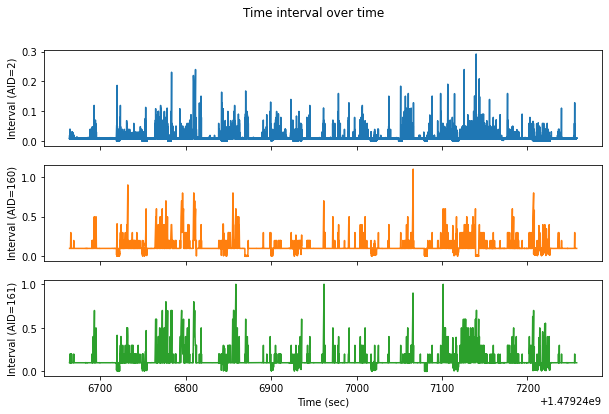

In [33]:
plot_time_intervals(df_challenge, [2,160,161])

Q. 2, 160, 161인 arbitration_id에 대해 정상 데이터셋과 공격 데이터셋에 어떤 차이가 있는가?

In [34]:
append_col_interval(df_challenge) # it takes a time.
df_challenge['predicted_as'] = df_challenge.apply(detect_intrusion_interval, axis='columns')

In [35]:
df_challenge[df_challenge['predicted_as'] == 1]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label,label_desc,interval,predicted_as
47304,1479246689.43866,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',25.27694,1,DoS,0.00071,1
47307,1479246689.43939,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',25.27767,1,DoS,0.00073,1
47309,1479246689.43988,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',25.27816,1,DoS,0.00049,1
47312,1479246689.44064,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',25.27892,1,DoS,0.00076,1
47314,1479246689.44114,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',25.27942,1,DoS,0.00049,1
...,...,...,...,...,...,...,...,...,...,...
978830,1479247237.85213,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',573.69041,1,DoS,0.00067,1
978832,1479247237.85301,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',573.69128,1,DoS,0.00087,1
978834,1479247237.85350,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',573.69178,1,DoS,0.00050,1
978836,1479247237.85427,0,000,8,b'\x00\x00\x00\x00\x00\x00\x00\x00',573.69255,1,DoS,0.00077,1


---

# 4. Entropy-based intrusion detection

Shannon's diversity index를 통해 임계치를 결정하고, 임계치를 벗어난 상태를 공격으로 식별한다.

**Shannon's diversity index**
$$ H' = - \sum_{i=1}^{n}{p_i\log p_i} $$
where, 
- $n$: 차량 내부 네트워크에서 사용되는 `Arbitration_ID`의 수
- $p_i$: `Arbitration_ID`가 차지하는 비율


## 4.1. Entropy 계산 실습

In [36]:
df_sample = df_benign[:4]  #df_benign 의 첫 네 개 메시지만 일부 추출
print(df_sample['arbitration_id'].value_counts())

1264    2
1680    1
1520    1
Name: arbitration_id, dtype: int64


|arbitration_id|count|$p_i$|
|---|---|---|
|1264|2|0.5|
|1680|1|0.25|
|1520|1|0.25|

$$ n=3, p_1=\frac{2}{4}, p_2=\frac{1}{4}, p_3=\frac{1}{4} $$

$$ H' = -(p_1 log(p_1) + p_2 log(p_2) + p_3 log(p_3)) $$

In [37]:
# Entropy 계산 함수
def calculate_entropy(counts: list) -> float: # counts = [2, 1, 1]
    ent = 0.0
    total_count = sum(counts) # 4
    for count in counts:
        pi = count/total_count # 2/4 or 1/4
        log_pi = np.log(pi) # log(...)
        ent += (pi * log_pi) # ... * log(...)
    return -ent

print(calculate_entropy(df_sample['arbitration_id'].value_counts()))

1.0397207708399179


#### 4.1.1. Entropy가 변화하는 과정 살펴보기 -- $n$이 커질 때 (=arbitration_id의 종류가 많아 질 때)

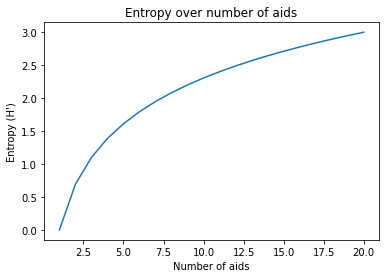

In [38]:
results = []
for num_of_aids in range(1, 21):
    counts = [2, ] * num_of_aids # [2] / [2, 2] / [2, 2, 2] / [2, 2, 2, 2], ...
    results.append(calculate_entropy(counts))

plt.title('Entropy over number of aids')
plt.xlabel('Number of aids')
plt.ylabel("Entropy (H')")
plt.plot(range(1, 21), results)


#### 4.1.2. Entropy가 변화하는 과정 살펴보기 -- $p_i$ 값이 커질 때 (=특정 arbitration_id가 차지하는 비율이 높아질 때)

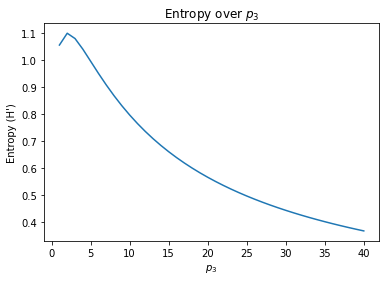

In [39]:
results = []
for count in range(1, 41):
    counts = [2, 2, count] # [2] / [2, 2] / [2, 2, 2] / [2, 2, 2, 2], ...
    results.append(calculate_entropy(counts))

plt.title('Entropy over $p_3$')
plt.xlabel('$p_3$')
plt.ylabel("Entropy (H')")
plt.plot(range(1, 41), results)


## 4.2 정상 데이터셋을 이용한 entropy threshold 결정

- Entropy-based IDS는 정상 범위의 Entropy 값을 벗어난 Entropy 값이 출력될 경우, 공격으로 탐지함
- 따라서 가장 먼저 Entropy의 정상 범위를 측정해야함
- 정상 범위를 측정하기 위해, Entropy 분포를 확인함

entropy 0.5초 단위로 계산함

In [40]:
def append_col_entropy(df: pd.DataFrame, TIME_WINDOW: float=0.5):
    df['entropy'] = np.nan
    for t_begin in np.arange(0, df['timedelta'].max(), TIME_WINDOW):
        t_end = t_begin + TIME_WINDOW
        df_timewindow = df[(t_begin <= df['timedelta']) & (df['timedelta'] < t_end)]
        counts = df_timewindow['arbitration_id'].value_counts()
        df.loc[df_timewindow.index, 'entropy'] = calculate_entropy(counts)
append_col_entropy(df_benign) # it takes a time.

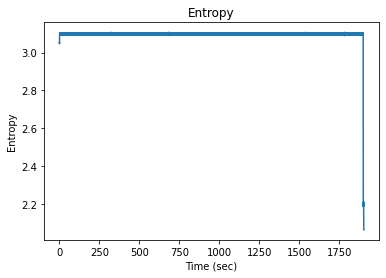

In [41]:
plt.title('Entropy')
plt.xlabel('Time (sec)')
plt.ylabel('Entropy')
plt.plot(df_benign['timedelta'], df_benign['entropy'])

침입 탐지를 위한 threshold 결정

In [42]:
entropy_mean, entropy_std = df_benign['entropy'].mean(), df_benign['entropy'].std()
print('정상 상황에서의 entropy 평균={}, 표준편차={}'.format(entropy_mean, entropy_std))

entropy_min = entropy_mean - entropy_std*2
entropy_max = entropy_mean + entropy_std*2
print('정상 entropy 범위: {} ~ {}'.format(entropy_min, entropy_max))

정상 상황에서의 entropy 평균=3.0975892935998948, 표준편차=0.026188637620532862
정상 entropy 범위: 3.045212018358829 ~ 3.1499665688409606


## 4.3 공격 상황에서 Entropy-based IDS 적용

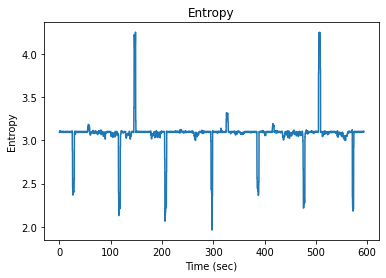

In [43]:
append_col_entropy(df_challenge) # entropy 필드 추가 # it takes a time
plt.title('Entropy')
plt.xlabel('Time (sec)')
plt.ylabel('Entropy')
plt.plot(df_challenge['timedelta'], df_challenge['entropy'])

# # figure에 레이블을 RGB로 표시하기
# dict_color = {'DoS': 'red', 'Fuzzy': 'green', 'Replay': 'blue'}
# t = df_challenge.timestamp.min()
# for ts_start, ts_end, label in labels:
#     plt.axvspan(ts_start-t, ts_end-t, color=dict_color[label], alpha=0.3)

In [44]:
def detect_intrusion_entropy(entropy: float) -> int: # entropy를 이용한 침입 탐지 함수
    if entropy_min < entropy < entropy_max:
        return 0
    else:
        return 1

df_challenge['predicted_as2'] = df_challenge['entropy'].map(detect_intrusion_entropy) # 탐지 결과 저장

In [45]:
df_challenge['predicted_as2'] = df_challenge['entropy'].map(detect_intrusion_entropy)
df_challenge[df_challenge['predicted_as2'] == 1]

,timestamp,arbitration_id,control_field,dlc,payload,timedelta,label,label_desc,interval,predicted_as,entropy,predicted_as2
46765,1479246689.16222,304,000,8,b'\x05\x80\x00\xff\xcd\x7f\x04\xe1',25.00050,0,benign,0.01098,0,2.88874,1
46766,1479246689.16245,305,000,8,b'\x17\x80\x00\x00N\x80\x04I',25.00072,0,benign,0.01096,0,2.88874,1
46767,1479246689.16269,320,000,8,b'\x00\x00\x00\x00\x16\x03$0',25.00097,0,benign,0.01100,0,2.88874,1
46768,1479246689.16374,688,000,5,b'\xbd\xff\x00\x07\xfe',25.00202,0,benign,0.00995,0,2.88874,1
46769,1479246689.16683,704,000,8,b'\x14\x00\x00\x00\x00\x00\x00\x00',25.00510,0,benign,0.00999,0,2.88874,1
...,...,...,...,...,...,...,...,...,...,...,...,...
979432,1479247238.15711,1349,000,8,b'\xd8\x00\x00\x8c\x00\x00\x00\x00',573.99539,0,benign,0.00950,0,2.93024,1
979433,1479247238.15932,1087,000,8,b'\x00@`\xff\\K\x08\x00',573.99760,0,benign,0.01000,0,2.93024,1
979434,1479247238.15956,880,000,8,b'\x00 \x00\x00\x00\x00\x00\x00',573.99784,0,benign,0.00999,0,2.93024,1
979435,1479247238.15980,1088,000,8,b'\xff\x00\x00\x00\xffK\x08\x00',573.99808,0,benign,0.00999,0,2.93024,1



## 4.4. sklearn 라이브러리를 이용한 탐지 성능 평가

In [46]:
a = df_challenge[df_challenge['predicted_as2'] == 1]
print(accuracy_score(a.label, a.predicted_as2))
print(confusion_matrix(a.label, a.predicted_as2))

0.8501628664495114
[[    0 17066]
 [    0 96831]]


Q. benign traffic이 침입 탐지 시스템에 의해 탐지된 이유는?
- time window 내에 benign, injected 메시지가 모두 포함된 경우
- entropy의 최소/최댓값의 선택

Q. 탐지 성능 개선 방안?
- `append_col_entropy()` 함수의 `TIME_WINDOW` 인자 조절
- 침입 탐지를 위한 entropy 범위 조절
